In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [3]:
os.chdir('C:\\Users\\arj26323\\Documents\\Data')
os.getcwd()

from joblib import load

# Load the full pipeline
pipe = load('rf_pipeline.joblib')

# Use it to predict just like before
# y_pred = pipe.predict()

In [4]:
##Predict for LTER shapefile
gce_clip = 'F:/Wetlands shapefiles/GCE domain/GCE_LTER_boundary.shp' ##Now, do the entire GA coast!
gce = geemap.shp_to_ee(gce_clip)

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)
Map.addLayer(gce, {}, 'GCE boundary')
# Map

In [5]:
##Functions

##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

#12/08/22 - adding CALIBRATED FLATS
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

##Pixel extraction functions - addDate for dateless images/collections
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('imagedate').toInt())

##For Landsat images:
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 30,
        tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
    )
    return feature

##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

#Resampling daymet collection to 30m
def resamp(img):
    resampled = img.reproject(
        crs = 'EPSG:4326',
        scale = 30
    ).resample('bilinear')
    return resampled

In [6]:
#Datasets
#DEM
dem = resamp((ee.Image('USGS/3DEP/10m').clip(gce))) ##This is 1/3 arc second, or 10 m.

#Landsat
ls5_collect = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(gce).map(maskL8sr).map(addFLATSL5)
ls7_collect = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(gce).map(maskL8sr).map(addFLATSL7)
ls8_collect = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(gce).map(maskL8sr).map(addFLATSL8)
ls9_collect = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(gce).map(maskL8sr).map(addFLATSL8)
ultra_col = ls8_collect.merge(ls5_collect).merge(ls7_collect).merge(ls9_collect)

#Gridmet (not used?)
gridmet = ee.ImageCollection('GRIDMET/DROUGHT').filterBounds(gce).map(resamp)

#Daymet
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(gce).map(resamp)

In [7]:
##EOYB for Year
yr = 2024

test_set = ultra_col.filterDate(ee.Date(f'{yr}'), ee.Date(f'{yr+1}'))
dm_test = daymet.filterDate(ee.Date(f'{yr}'), ee.Date(f'{yr+1}'))
gm_test = gridmet.filterDate(ee.Date(f'{yr}'), ee.Date(f'{yr+1}'))

In [8]:
#Index functions to be called
def add_evi(img):
    evi = img.expression(
        '((NIR - Red) * 2.5) / (NIR + 6 * Red + 7.5 * Blue + 1)', {
            'NIR': img.select('NIR'),
            'Red': img.select('Red'),
            'Blue': img.select('Blue')
        }).rename('evi')
    return img.addBands(evi)

In [9]:
def get_elevation():
    return dem.select('elevation').rename('elevation').clip(gce)

#Daymet
def get_srad_peak(year):
    start_date = ee.Date(f'{year}-08-01')
    end_date = ee.Date(f'{year}-10-31')
    
    return dm_test.select('srad').mean().rename('srad_peak').clip(gce)

#Gridmet
def get_eddi2y(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')
    
    return gm_test.select('eddi2y').mean().rename('eddi2y').clip(gce)

#Landsat functions
#1
def get_nd_swir2_nir_median_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_median = nd_images.median().rename('nd_swir2_nir_median_01_12').clip(gce)
    return nd_median

#2
def get_nd_swir2_nir_median_05_10(year):
    start_date = ee.Date(f'{year}-05-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_median = nd_images.median().rename('nd_swir2_nir_median_05_10').clip(gce)
    return nd_median


#3
def get_nd_swir2_nir_mean_05_10(year):
    start_date = ee.Date(f'{year}-05-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_mean = nd_images.mean().rename('nd_swir2_nir_mean_05_10').clip(gce)
    return nd_mean



#4
def get_evi_mean_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B4', 'SR_B3', 'SR_B1']).rename(['NIR', 'Red', 'Blue'])
        img_l89 = img.select(['SR_B5', 'SR_B4', 'SR_B2']).rename(['NIR', 'Red', 'Blue'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    evi_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(add_evi)

    return evi_images.select('evi').mean().rename('evi_mean_01_12')


#5
def get_evi_max_05_10(year):
    start_date = ee.Date(f'{year}-05-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B4', 'SR_B3', 'SR_B1']).rename(['NIR', 'Red', 'Blue'])
        img_l89 = img.select(['SR_B5', 'SR_B4', 'SR_B2']).rename(['NIR', 'Red', 'Blue'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    evi_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(add_evi)

    return evi_images.select('evi').max().rename('evi_max_05_10')


#6
def get_nd_swir2_nir_median_08_10(year):
    start_date = ee.Date(f'{year}-08-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_median = nd_images.median().rename('nd_swir2_nir_median_08_10').clip(gce)
    return nd_median


#7
def get_nd_swir2_nir_mean_08_10(year):
    start_date = ee.Date(f'{year}-08-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_mean = nd_images.mean().rename('nd_swir2_nir_mean_08_10').clip(gce)
    return nd_mean



#8
def get_nd_swir2_nir_min_05_10(year):
    start_date = ee.Date(f'{year}-05-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_min = nd_images.min().rename('nd_swir2_nir_min_05_10').clip(gce)
    return nd_min


#9
def get_swir1_max_05_10(year):
    start_date = ee.Date(f'{year}-05-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B5']).rename(['SWIR1'])
        img_l89 = img.select(['SR_B6']).rename(['SWIR1'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    swir1_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat)

    swir1_max = swir1_images.select('SWIR1').max().rename('SWIR1_band_max_05_10').clip(gce)
    return swir1_max


#10
def get_nd_r_g_mean_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B3', 'SR_B2']).rename(['Red', 'Green'])
        img_l89 = img.select(['SR_B4', 'SR_B3']).rename(['Red', 'Green'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['Red', 'Green']).rename('nd_r_g'))

    nd_mean = nd_images.mean().rename('nd_r_g_mean_01_12').clip(gce)
    return nd_mean


#11
def get_nd_r_g_min_03_05(year):
    start_date = ee.Date(f'{year}-03-01')
    end_date = ee.Date(f'{year}-05-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B3', 'SR_B2']).rename(['Red', 'Green'])
        img_l89 = img.select(['SR_B4', 'SR_B3']).rename(['Red', 'Green'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['Red', 'Green']).rename('nd_r_g'))

    nd_min = nd_images.min().rename('nd_r_g_min_03_05').clip(gce)
    return nd_min


#12
def get_nd_g_b_mean_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B2', 'SR_B1']).rename(['Green', 'Blue'])
        img_l89 = img.select(['SR_B3', 'SR_B2']).rename(['Green', 'Blue'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['Green', 'Blue']).rename('nd_g_b'))

    nd_mean = nd_images.mean().rename('nd_g_b_mean_01_12').clip(gce)
    return nd_mean


#13
def get_nd_swir2_nir_mean_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_mean = nd_images.mean().rename('nd_swir2_nir_mean_01_12').clip(gce)
    return nd_mean


#14
def get_red_max_05_10(year):
    start_date = ee.Date(f'{year}-05-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B3']).rename(['Red'])
        img_l89 = img.select(['SR_B4']).rename(['Red'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    red_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat)

    red_max = red_images.select('Red').max().rename('Red_band_max_05_10').clip(gce)
    return red_max


#15
def get_red_mean_03_05(year):
    start_date = ee.Date(f'{year}-03-01')
    end_date = ee.Date(f'{year}-05-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B3']).rename(['Red'])
        img_l89 = img.select(['SR_B4']).rename(['Red'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    red_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat)

    red_mean = red_images.select('Red').mean().rename('Red_band_mean_03_05').clip(gce)
    return red_mean


#16
def get_evi_mean_08_10(year):
    start_date = ee.Date(f'{year}-08-01')
    end_date = ee.Date(f'{year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B4', 'SR_B3', 'SR_B1']).rename(['NIR', 'Red', 'Blue'])
        img_l89 = img.select(['SR_B5', 'SR_B4', 'SR_B2']).rename(['NIR', 'Red', 'Blue'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    evi_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(add_evi)

    return evi_images.select('evi').mean().rename('evi_mean_08_10')


#17
def get_evi_median_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B4', 'SR_B3', 'SR_B1']).rename(['NIR', 'Red', 'Blue'])
        img_l89 = img.select(['SR_B5', 'SR_B4', 'SR_B2']).rename(['NIR', 'Red', 'Blue'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    evi_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(add_evi)

    return evi_images.select('evi').median().rename('evi_median_01_12')


#18
def get_evi_max_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B4', 'SR_B3', 'SR_B1']).rename(['NIR', 'Red', 'Blue'])
        img_l89 = img.select(['SR_B5', 'SR_B4', 'SR_B2']).rename(['NIR', 'Red', 'Blue'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    evi_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(add_evi)

    return evi_images.select('evi').max().rename('evi_max_01_12')


#19
def get_nd_swir2_nir_mean_01_12_lag1(year):
    lag_year = year -1
    start_date = ee.Date(f'{lag_year}-01-01')
    end_date = ee.Date(f'{lag_year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_mean = nd_images.mean().rename('nd_swir2_nir_mean_01_12_lag1').clip(gce)
    return nd_mean


#20
def get_nd_swir2_nir_median_05_10_lag1(year):
    lag_year = year -1
    start_date = ee.Date(f'{lag_year}-05-01')
    end_date = ee.Date(f'{lag_year}-10-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_median = nd_images.median().rename('nd_swir2_nir_median_05_10_lag1').clip(gce)
    return nd_median


#21
def get_nd_swir2_nir_min_01_12(year):
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    def harmonize_landsat(img):
        sat = ee.String(img.get('SPACECRAFT_ID'))

        is_l5 = sat.index('LANDSAT_5').gte(0)
        is_l7 = sat.index('LANDSAT_7').gte(0)

        img_l57 = img.select(['SR_B7', 'SR_B4']).rename(['SWIR2', 'NIR'])
        img_l89 = img.select(['SR_B7', 'SR_B5']).rename(['SWIR2', 'NIR'])

        return ee.Image(
            ee.Algorithms.If(is_l5,
                             img_l57,
                             ee.Algorithms.If(is_l7, img_l57, img_l89))
        ).copyProperties(img, img.propertyNames())

    nd_images = ultra_col.filterDate(start_date, end_date) \
        .map(harmonize_landsat) \
        .map(lambda img: img.normalizedDifference(['SWIR2', 'NIR']).rename('nd_swir2_nir'))

    nd_min = nd_images.min().rename('nd_swir2_nir_min_01_12').clip(gce)
    return nd_min



#Percent_flooding
def get_percent_flooding():
    def threshold_image(img):
        # Binary mask where 'flats' >= 0.2
        flooded = img.select('flats').gte(0.2)
        return flooded.copyProperties(img, img.propertyNames())

    # Apply threshold to all images in the collection
    flooding_binary = ultra_col.map(threshold_image)

    # Count number of times flats >= 0.2
    flooded_count = flooding_binary.sum()

    # Count total valid observations for each pixel
    total_count = ultra_col.map(lambda img: img.select('flats').mask().gt(0)).sum()

    # Calculate percent flooding and clip to your region
    percent_flooding = flooded_count.divide(total_count.max(1)).rename('Percent_flooding')

    return percent_flooding.clip(gce)

In [14]:
# #Testing
# x = get_elevation()
# y = get_percent_flooding()

# vizParams = {
#   'bands': ['Percent_flooding'],
#   'min': 0,
#   'max': 1,
#   'gamma': [1]
# }
# Map.addLayer(y, vizParams, 'Percent flooding')
# Map


###NOTE: Percent flooding looks mostly correct, but seems to max out at 0.5, even in open water areas. WHY?

In [11]:
##STACKING THE BANDS AND MAKING THE MAPS

year_x = yr

stack = ee.Image.cat([
    get_elevation(),
    get_nd_swir2_nir_median_01_12(year_x),
    get_nd_swir2_nir_median_05_10(year_x),
    get_nd_swir2_nir_mean_05_10(year_x),
    get_evi_mean_01_12(year_x),
    get_evi_max_05_10(year_x),
    get_nd_swir2_nir_median_08_10(year_x),
    get_srad_peak(year_x),
    get_nd_swir2_nir_mean_08_10(year_x),
    get_nd_swir2_nir_min_05_10(year_x),
    get_percent_flooding(),
    get_swir1_max_05_10(year_x),
    get_nd_r_g_mean_01_12(year_x),
    get_nd_swir2_nir_mean_01_12(year_x),
    get_nd_r_g_min_03_05(year_x),
    get_eddi2y(year_x),
    get_evi_mean_08_10(year_x),
    get_nd_swir2_nir_min_01_12(year_x),
    get_red_mean_03_05(year_x),
    get_nd_g_b_mean_01_12(year_x),
    get_nd_swir2_nir_mean_01_12_lag1(year_x),
    get_nd_swir2_nir_median_05_10_lag1(year_x),
    get_evi_max_01_12(year_x),
    get_evi_median_01_12(year_x),
    get_red_max_05_10(year_x)
])

In [61]:
##Visualize stack
# Map.addLayer(stack, {}, 'stack')
# Map

In [62]:
# TILES for batch export

# Create a grid of tiles (e.g., 10km x 10km)
grid_size = 3000  # Tile size in meters
tiles = geemap.fishnet(gce, rows=5, cols=5)

##Visualize the grid on a map
# Map = geemap.Map(center=[31.5, -81], zoom=10)
# Map.addLayer(tiles, {}, "Tiles")
# Map.addLayer(gce, {}, "GCE")
# Map

In [63]:
#Exporting the stack - batch export, as a single file is too large
os.chdir(f'F:\\Biomass tiffs\\Pred_{yr}')
os.getcwd()

# Function to process each tile
def process_tile(tile, tile_id):
    # Clip the stack to the tile geometry
    clipped_stack = stack.clip(tile)
  
    # Export each tile as GeoTIFF
    filename = os.path.join(out_dir, f'tile_{tile_id}_stacked.tif')
    geemap.ee_export_image(
        clipped_stack,
        filename=filename,
        scale=30,
        region=tile,
        file_per_band=False,
    )
    print(f"Exported: {filename}")

# Output directory
out_dir = f'F:\\Biomass tiffs\\Pred_{yr}'
os.makedirs(out_dir, exist_ok=True)


## Iterate through each tile in the grid - UNCOMMENT TO RUN EXPORT
tile_list = tiles.toList(tiles.size())
for i in range(tiles.size().getInfo()):
    tile = ee.Feature(tile_list.get(i)).geometry()
    process_tile(tile, i)

Generating URL ...
Please wait ...
An error occurred while downloading.
Exported: F:\Biomass tiffs\Pred_2010\tile_0_stacked.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Exported: F:\Biomass tiffs\Pred_2010\tile_1_stacked.tif
Generating URL ...
Please wait ...
Data downloaded to F:\Biomass tiffs\Pred_2010\tile_2_stacked.tif
Exported: F:\Biomass tiffs\Pred_2010\tile_2_stacked.tif
Generating URL ...
Please wait ...
Data downloaded to F:\Biomass tiffs\Pred_2010\tile_3_stacked.tif
Exported: F:\Biomass tiffs\Pred_2010\tile_3_stacked.tif
Generating URL ...
Please wait ...
Data downloaded to F:\Biomass tiffs\Pred_2010\tile_4_stacked.tif
Exported: F:\Biomass tiffs\Pred_2010\tile_4_stacked.tif
Generating URL ...
Please wait ...
Data downloaded to F:\Biomass tiffs\Pred_2010\tile_5_stacked.tif
Exported: F:\Biomass tiffs\Pred_2010\tile_5_stacked.tif
Generating URL ...
Please wait ...
Data downloaded to F:\Biomass tiffs\Pred_2010\tile_6_stacked.tif
Exported: F:\Biomass

In [66]:
##Cleanup, in case any tiles failed to export: 0,1,16
# out_dir = f"F:\\Biomass tiffs\\Pred_{yr}"
# os.makedirs(out_dir, exist_ok=True)
# tile = ee.Feature(tile_list.get(0)).geometry()
# process_tile(tile, 0)

Generating URL ...
Please wait ...
Data downloaded to F:\Biomass tiffs\Pred_2010\tile_0_stacked.tif
Exported: F:\Biomass tiffs\Pred_2010\tile_0_stacked.tif


In [20]:
# xargs = df0[['elevation','nd_swir2_nir_median_01_12','nd_swir2_nir_median_05_10','nd_swir2_nir_mean_05_10','evi_mean_01_12',
#              'evi_max_05_10','nd_swir2_nir_median_08_10','srad_peak','nd_swir2_nir_mean_08_10','nd_swir2_nir_min_05_10',
#              'Percent_flooding','SWIR1_band_max_05_10','nd_r_g_mean_01_12','nd_swir2_nir_mean_01_12',
#              'nd_r_g_min_03_05','eddi2y','evi_mean_08_10','nd_swir2_nir_min_01_12','Red_band_mean_03_05','nd_g_b_mean_01_12',
#             'nd_swir2_nir_mean_01_12_lag1', 'nd_swir2_nir_median_05_10_lag1', 'evi_max_01_12', 'evi_median_01_12',
#             'Red_band_max_05_10']]

In [67]:
import rasterio

tile_dir = f"F:/Biomass tiffs/Pred_{yr}" 
tile_paths = glob.glob(os.path.join(tile_dir, "*.tif"))

predicted_tiles = []

for tile_path in tile_paths:
    with rasterio.open(tile_path) as src:
        img = src.read()  # shape: (bands, rows, cols)
        profile = src.profile
        
        # Reshape to (n_samples, n_features)
        bands, rows, cols = img.shape
        img_reshaped = img.reshape(bands, -1).T  # (rows*cols, bands)
        
        # Handle no-data (e.g., -9999) — replace or mask
        mask = np.any(img_reshaped == -9999, axis=1)
        img_reshaped[mask] = np.nan
        
        # Predict only on valid rows
        valid_mask = ~np.isnan(img_reshaped).any(axis=1)
        preds = np.full((img_reshaped.shape[0],), np.nan)
        preds[valid_mask] = pipe.predict(img_reshaped[valid_mask])
        
        # Reshape back to (rows, cols)
        pred_tile = preds.reshape((rows, cols)).astype(np.float32)
        predicted_tiles.append((pred_tile, profile))

In [68]:
output_dir = f"F:/Biomass tiffs/Temp/{yr}"
os.makedirs(output_dir, exist_ok=True)

temp_files = []

for i, (pred_tile, profile) in enumerate(predicted_tiles):
    profile.update(count=1, dtype="float32", nodata=np.nan)
    temp_path = os.path.join(output_dir, f"pred_tile_{i}.tif")
    with rasterio.open(temp_path, "w", **profile) as dst:
        dst.write(pred_tile, 1)
    temp_files.append(temp_path)
    
from rasterio.merge import merge

srcs = [rasterio.open(path) for path in temp_files]
merged, merged_transform = merge(srcs)

# Use the profile from the first tile, update dimensions and transform
out_meta = srcs[0].meta.copy()
out_meta.update({
    "height": merged.shape[1],
    "width": merged.shape[2],
    "transform": merged_transform,
    "nodata": np.nan
})

# Save final merged raster
with rasterio.open(f"F:/Biomass tiffs/Output/pred{yr}.tif", "w", **out_meta) as dest:
    dest.write(merged)

In [69]:
file_path = f"F:/Biomass tiffs/Output/pred{yr}.tif"

with rasterio.open(file_path) as src:
    print(f"Number of bands: {src.count}")
    print("Band indexes:", src.indexes)
    print("Metadata:", src.tags())  ##DO BANDS CORRESPOND TO CORRECT PREDICTOR? AND WHAT IS UP WITH FLOODING PERCENTAGE?
    
with rasterio.open(file_path) as src:
    for i in src.indexes:
        desc = src.descriptions[i - 1]
        print(f"Band {i}: {desc}")  ##HOW CAN I ADD THESE?

Number of bands: 1
Band indexes: (1,)
Metadata: {'AREA_OR_POINT': 'Area'}
Band 1: None


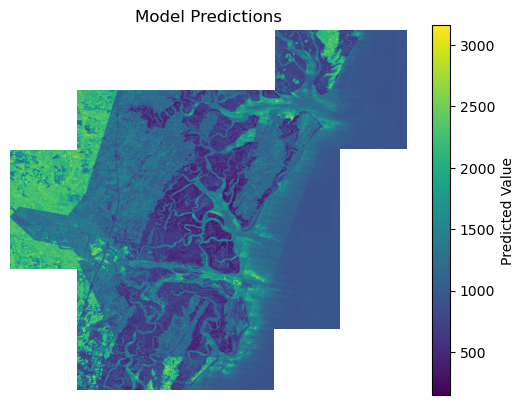

In [70]:
import rasterio
import matplotlib.pyplot as plt

# Open your merged raster
with rasterio.open(file_path) as src:
    prediction_array = src.read(1)  # Read the first band (predictions)
    plt.imshow(prediction_array, cmap='viridis')
    plt.colorbar(label='Predicted Value')
    plt.title("Model Predictions")
    plt.axis('off')
    plt.show()

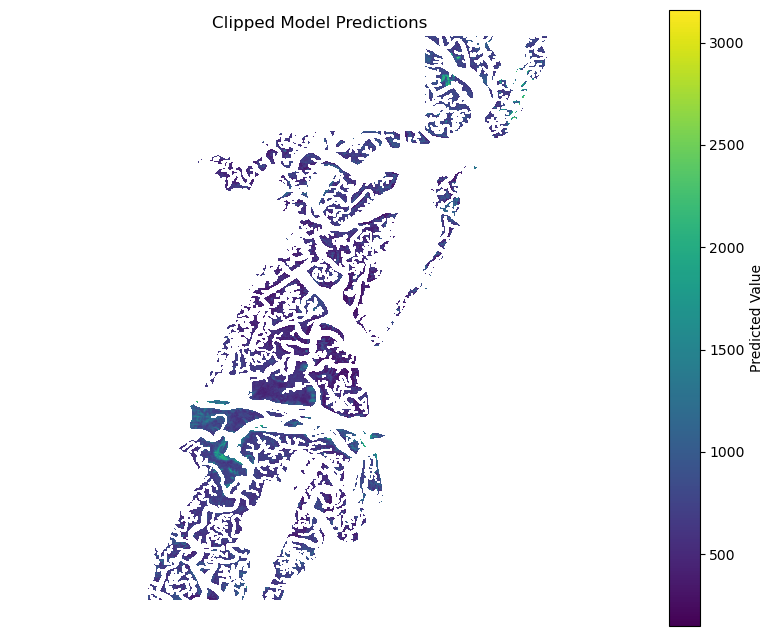

In [71]:
##Clipping to GA_estuaries file
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Paths
raster_path = file_path
shapefile_path = "F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_estuaries.shp"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")  # Optional: match CRS if needed

# Open the raster and clip it
with rasterio.open(raster_path) as src:
    # Ensure CRS matches
    if src.crs != gdf.crs:
        gdf = gdf.to_crs(src.crs)

    # Convert GeoDataFrame geometry to GeoJSON-like mapping
    shapes = gdf.geometry.values
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

# Update metadata to match clipped output
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Plot the clipped prediction
plt.figure(figsize=(10, 8))
plt.imshow(out_image[0], cmap='viridis')
plt.colorbar(label='Predicted Value')
plt.title("Clipped Model Predictions")
plt.axis('off')
plt.show()

In [72]:
#Export clipped image
clipped_path = f"F:/Biomass tiffs/Output/Clippy/clipped_{yr}.tif"
with rasterio.open(clipped_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
#Finito